# Factor Analysis of Momentum Investment

## Import of Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
from pandas_datareader import data as pdr
from sklearn.model_selection import TimeSeriesSplit
from arch.bootstrap import StationaryBootstrap
import yfinance as yf
import warnings
from datetime import datetime, timedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

## Functions for Data Collection and Pre-processing

In [2]:
#Function to load the data (for purpose of simplicity the data is being taken from yahoo finance)
#This function is called and the parameters such as the tickers, start date and end date is passed.
def load_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            data[ticker] = stock_data
            
        except Exception as e:
            print(f"Error in fetching data for {ticker}: {e}")
            data[ticker]=None
    
    dfs = []
    for ticker, data in data.items():
        df = pd.DataFrame(data)
        df.reset_index(inplace=True)
        df['Ticker'] = ticker
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df.set_index(['Ticker', combined_df.index])

In [3]:
# This fucntion combines all the asset class data into one single dataframe.

def combine_asset_class_data(equity_data, bond_data, currency_data, commodity_data):

    # For each asset class, create a representative index
    # This could be an equal-weighted average of all assets in each class
    equity_index = equity_data.mean(axis=1)
    bond_index = bond_data.mean(axis=1)
    currency_index = currency_data.mean(axis=1)
    commodity_index = commodity_data.mean(axis=1)
    
    # Combine into a single DataFrame using outer join
    combined_data = pd.concat([
        equity_index.rename('Equity'),
        bond_index.rename('Bond'),
        currency_index.rename('Currency'),
        commodity_index.rename('Commodity')
    ], axis=1, join='outer')
    
    # Print information about the combined data
    print("\nCombined data info:")
    print(combined_data.info())
   
    
    # Check for any completely empty rows or columns
    empty_rows = combined_data.index[combined_data.isnull().all(axis=1)]
    empty_cols = combined_data.columns[combined_data.isnull().all(axis=0)]
    
    
    return combined_data

##  Functions for Momentum Strategy Implementation

In [4]:
#This function calculates the momentum returns and eventually helps in creation of the portfolio based on the returns.

def momentum_returns_cal(data, look_back_period=12, holding_period=1):
    if 'Date' not in data.columns:
        print("Date column not present in the data.")
        return None
    
    data = data.set_index('Date')
    
    returns = data['Adj Close'].pct_change()
    momentum = returns.rolling(window=look_back_period).sum()
    future_returns = returns.shift(-holding_period).rolling(window=holding_period).sum()
    
    result = pd.DataFrame({
        'Momentum': momentum, 
        'Future_Returns': future_returns,
        'Adj Close': data['Adj Close']
    })
    result = result.reset_index()
    
    return result


In [5]:
# The below function uses the result from momentum calculation function and ranks them to find the best momentum performers
# and create the portfolio.

def create_best_portfolio(data, percentile=0.9):
    
    # Rank based on momentum
    ranked = data['Momentum'].rank(pct=True)
    
    # Select top performers
    top_performers = ranked >= percentile
    
    # Create a mask for the selected stocks
    mask = top_performers
    
    # Apply the mask to get the portfolio constituents
    portfolio = data[mask]
    
    # Calculate equal weights for the selected stocks
    portfolio['Weight'] = 1 / len(portfolio)
    
    return portfolio[['Date', 'Adj Close', 'Momentum', 'Weight']]

# The below function helps in the calculation of the returns for the best portfolio created using the above function.

def backtest_portfolio(portfolio, data):
    
    # Calculate returns
    data['Returns'] = data['Adj Close'].pct_change()
    
    # Merge portfolio weights with returns
    merged = pd.merge(portfolio, data[['Date', 'Returns']], on=['Date'])
    
    # Calculate weighted returns
    merged['Weighted_Returns'] = merged['Weight'] * merged['Returns']
    
    # Sum up weighted returns for each date
    portfolio_returns = merged.groupby('Date')['Weighted_Returns'].sum().reset_index()
    portfolio_returns.columns = ['Date', 'Portfolio_Return']
    
    # Calculate cumulative returns
    portfolio_returns['Cumulative_Return'] = (1 + portfolio_returns['Portfolio_Return']).cumprod() - 1
    
    return portfolio_returns

In [6]:
#Function to run momentum strategy
def run_momentum_strategy(data, look_back_period=12, holding_period=1, n_portfolios=10):
    momentum_data = momentum_returns_cal(data, look_back_period, holding_period)
    portfolios = create_best_portfolio(momentum_data)
    portfolio_returns = backtest_portfolio(portfolios,data)
    return portfolio_returns[['Date', 'Portfolio_Return']].set_index('Date')

In [7]:
#Function to ensure unique indices
def ensure_unique_index(df, name):
    if not df.index.is_unique:
        print(f"Index of {name} is not unique. Dropping duplicates.")
        df = df[~df.index.duplicated(keep='first')]
    return df

## Functions for Factor Analysis

In [8]:
# Function to calculate additional factors

def cal_additional_factors(data):
    
    if data.empty:
        print("Empty data: cannot calculate addtional factors.")
        return pd.DataFrame()
    
    if 'Date' not in data.columns:
        print("Date column not found in data. Skipping additional factor calculation.")
        return pd.DataFrame()
    
    dates = data['Date']
  
    data = data.set_index('Date')
    
    adj_close = data['Adj Close']
    volume = data['Volume']
    

    #Size factor (using log of market cap as proxy)
    size = np.log(np.where(adj_close * volume > 0, adj_close * volume, np.nan))
    
    #Value factor(using book-to-market ratio as proxy)
    value = 1 / (adj_close / volume)
    
    #Market Capilization
    market_cap = adj_close * volume
    
    #Time-Value risk (using term spread as proxy)
    time_value_risk = adj_close.pct_change(252) - adj_close.pct_change(30)
    
    
    #Liquidity risk (using trading volume as proxy)
    liquidity_risk = volume.rolling(30).std() / volume.rolling(30).mean()

    #Quality of asset (using return on equity as proxy)
    quality = adj_close.pct_change(252) / (adj_close / volume)

    #Underreaction (using short-term reversal proxy)
    
    underreaction = -adj_close.pct_change(5)
    
    #Overreaction (using long-term reversal as proxy)
   
    overreaction = -adj_close.pct_change(252)
    
    factordf =  pd.DataFrame({
                        'Size' : size,
                        'Value' : value,
                        'MarketCap' : market_cap,
                        'TimeValueRisk' : time_value_risk,
                        'LiquidityRisk' : liquidity_risk,
                        'Quality' : quality,
                        'Underreaction' : underreaction,
                        'Overreaction' : overreaction
                        })
    factordf.index = dates
    
    #Replace infinite values with a large finite number
    large_number = 1e15
    factordf = factordf.replace([np.inf, -np.inf], [large_number, -large_number])
    
    #Fill NaN values using forward fill followed by backward fill
    factordf = factordf.fillna(method='ffill').fillna(method='bfill')
    
    print(f"Calculated addtional factors. Shape: {factordf.shape}")
    return factordf

In [9]:
# The function below helps to analysis the both traditional and additional factors for each asset class and provide
# a visualization that helps in better understanding the effect of factors on the asset classes.

def factor_analysis(returns, factors, n_components=5):
    # Align data
    aligned_data = pd.concat([returns, factors], axis=1, join='inner')
    cleaned_returns = aligned_data[returns.name]
    cleaned_factors = aligned_data[factors.columns]
    
    if cleaned_factors.empty or cleaned_returns.empty:
        print("Empty DataFrame after alignment.")
        return None
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    cleaned_factors_imputed = pd.DataFrame(imputer.fit_transform(cleaned_factors),
                                           columns=cleaned_factors.columns,
                                           index=cleaned_factors.index)
    cleaned_returns_imputed = pd.Series(imputer.fit_transform(cleaned_returns.values.reshape(-1, 1)).flatten(),
                                        index=cleaned_returns.index,
                                        name=cleaned_returns.name)
    
    # Standardize the factors
    scaler = StandardScaler()
    scaled_factors = scaler.fit_transform(cleaned_factors_imputed)
    
    # Determine the number of components
    max_components = min(scaled_factors.shape[0], scaled_factors.shape[1])
    n_components = min(n_components, max_components)
    
    # Perform PCA 
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_factors)
    
    # Create a DataFrame of principal components
    pc_df = pd.DataFrame(
        data=principal_components,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=cleaned_factors_imputed.index
    )
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(pc_df, cleaned_returns_imputed, test_size=0.2, shuffle=False)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    

    
    # Create a 1x2 grid of subplots
    fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Factor Analysis Results', fontsize=16)
    
    # Plot 1: Explained Variance Ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    ax1.bar(range(1, n_components + 1), explained_variance_ratio)
    ax1.set_xlabel('Principal Component', fontsize=10)
    ax1.set_ylabel('Explained Variance Ratio', fontsize=10)
    ax1.set_title('Explained Variance Ratio by Principal Component', fontsize=12)
    ax1.set_xticks(range(1, n_components + 1))
    for i, v in enumerate(explained_variance_ratio):
        ax1.text(i + 1, v, f'{v:.2%}', ha='center', va='bottom', fontsize=8)
    
    # Plot 2: Factor Loadings
    loadings = pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_),
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=cleaned_factors_imputed.columns
    )
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax2, cbar=False)
    ax2.set_title('Factor Loadings', fontsize=12)
    ax2.set_xlabel('Principal Components', fontsize=10)
    ax2.set_ylabel('Factors', fontsize=10)
    

    
    plt.tight_layout()
    plt.show()
    

    return loadings, r2, mse
    


## Functions for Advanced Analytics

In [10]:
#Function to calculate transaction costs

def cal_transaction_costs(returns, turnover_rate, transaction_cost_rate):
    transaction_costs = returns.abs() * turnover_rate * transaction_cost_rate
    return returns - transaction_costs

In [11]:
#Function to perform bootstrap test

def bootstrap_test(returns, factors, n_iteration=1000, alpha=1.0):
    # Ensure returns is a DataFrame
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()

    # Ensure returns and factors have the same index
    common_index = returns.index.intersection(factors.index)
    returns = returns.loc[common_index]
    factors = factors.loc[common_index]

    # Check for and remove duplicate indices
    if returns.index.duplicated().any() or factors.index.duplicated().any():
        print("Duplicate indices found. Removing duplicates...")
        returns = returns.loc[~returns.index.duplicated(keep='first')]
        factors = factors.loc[~factors.index.duplicated(keep='first')]
        common_index = returns.index.intersection(factors.index)
        returns = returns.loc[common_index]
        factors = factors.loc[common_index]

#     print(f"Returns shape after removing duplicates: {returns.shape}")
#     print(f"Factors shape after removing duplicates: {factors.shape}")

    # Handle NaN values
#     print("Handling NaN values...")
    imputer = SimpleImputer(strategy='mean')
    returns_imputed = pd.DataFrame(imputer.fit_transform(returns), columns=returns.columns, index=returns.index)
    factors_imputed = pd.DataFrame(imputer.fit_transform(factors), columns=factors.columns, index=factors.index)

#     print(f"Returns shape after imputation: {returns_imputed.shape}")
#     print(f"Factors shape after imputation: {factors_imputed.shape}")

    if returns_imputed.shape[0] != factors_imputed.shape[0]:
        print(f"Returns ({returns_imputed.shape[0]} rows) and factors ({factors_imputed.shape[0]} rows) have different number of observations.")
        return None

    # Save the column names before standardizing
    factor_names = factors_imputed.columns

    # Standardize Factors
    scaler = StandardScaler()
    factors_standardized = scaler.fit_transform(factors_imputed)

    t_stats = []
    n_obs = returns_imputed.shape[0]
    for _ in range(n_iteration):
        try:
            indices = np.random.randint(0, n_obs, size=n_obs)
            
            boot_returns = returns_imputed.iloc[indices]
            boot_factors = factors_standardized[indices]
            
            model = Ridge(alpha=alpha).fit(boot_factors, boot_returns.values.ravel())
            t_stats.append(model.coef_)
        except Exception as e:
            print(f"Error in bootstrap iteration: {str(e)}")
            continue
            
    # Create DataFrame with factor names as columns
    t_stats_df = pd.DataFrame(t_stats, columns=factor_names)
    
    # Calculate mean and confidence intervals
    results = pd.DataFrame({
        'Mean': t_stats_df.mean(),
        'Std Dev': t_stats_df.std(),
        '2.5th Percentile': t_stats_df.quantile(0.025),
        '97.5th Percentile': t_stats_df.quantile(0.975)
    })
    
    # Calculate p-values
    t_values = results['Mean'] / results['Std Dev']
    results['p-value'] = 2 * (1 - stats.t.cdf(abs(t_values), df=n_iteration-1))
    
    # Sort results by absolute mean value
    results = results.sort_values('Mean', key=abs, ascending=False)
    
    return results

In [12]:
# The function helps to format the result of bootstrap test in more presentable and understandable format.

def format_bootstrap_results(results, asset_name, max_factors=10):
    print(f"\n{'=' * 80}")
    print(f"Bootstrap Test Results for {asset_name}")
    print(f"{'=' * 80}")
    
    # Show top factors by absolute mean
    top_factors = results.head(max_factors)
    
    print(f"{'Factor':<15} {'Mean':>10} {'Std Dev':>10} {'p-value':>10}")
    print(f"{'-' * 80}")
    for factor, row in top_factors.iterrows():
        print(f"{factor[:15]:<15} {row['Mean']:10.4f} {row['Std Dev']:10.4f} {row['p-value']:10.4f}")
    
    print(f"{'-' * 80}")
    print("Significant Factors (p < 0.05):")
    significant = results[results['p-value'] < 0.05]
    if not significant.empty:
        for factor, row in significant.iterrows():
            print(f"- {factor[:15]:<15}: Mean = {row['Mean']:.4f}, p-value = {row['p-value']:.4f}")
    else:
        print("No factors are statistically significant at the 0.05 level.")
    
    print(f"{'-' * 80}")
    print(f"Total factors: {len(results)}")
    print(f"Significant factors: {len(significant)}")
    print(f"Mean range: {results['Mean'].min():.4f} to {results['Mean'].max():.4f}")
    print(f"p-value range: {results['p-value'].min():.4f} to {results['p-value'].max():.4f}")
    print(f"{'=' * 80}\n")

## Data Collection and Preprocessing

In [13]:
# The data is collected using the function "load data" for the pre-specified dates and asset tickers.

if __name__ == "__main__":
    
    #Load Data
    start_date = '1990-01-01'
    end_date = '2024-08-07'
    
    
    equity_tickers = [
    'AAPL', 'MSFT', 'IBM', 'INTC', 'CSCO', 'ORCL', 'TXN', 'HPQ', 'XOM', 'CVX',
    'JNJ', 'PFE', 'MRK', 'PG', 'KO', 'PEP', 'WMT', 'GE', 'BA', 'CAT', 'MMM', 'DD',
    'UTX', 'HON', 'JPM', 'BAC', 'C', 'WFC', 'AXP', 'GS', 'MS', 'DIS', 'MCD', 'NKE',
    'HD', 'LOW', 'F', 'GM', 'T', 'VZ', 'AMGN', 'BMY', 'LLY', 'ABT', 'UNH', 'MDT',
    'SLB', 'HAL', 'COP', 'OXY', 'APA', 'EMR', 'GD', 'LMT', 'NOC', 'RTN', 'MO', 'PM',
    'CL', 'K', 'GIS', 'HNZ', 'SYY', 'KMB', 'EK', 'XRX', 'DOW', 'AA', 'IP', 'WY',
    'AVP', 'PBI', 'FDX', 'UPS', 'NSC', 'UNP', 'DAL', 'LUV', 'MAR', 'HLT', 'CCL',
    'MRK', 'SGP', 'LLY', 'BMY', 'ABT', 'BAX', 'TMO', 'DHR', 'BDX', 'SYK', 'BSX',
    'AME', 'ROK', 'ETN', 'PH', 'ITW', 'DE', 'CMI', 'IR', 'DOV', 'TXT', 'NYT',
    'OMC', 'IPG', 'HAS', 'MAT', 'HOG', 'WHR', 'PHM', 'LEN', 'DHI', 'MAS', 'SHW'
    ]
    
    bond_tickers = [
    '^TNX', '^TYX', '^FVX', '^IRX', 'AGG', 'BND', 'LQD', 'HYG', 'JNK', 'MUB',
    'TLT', 'IEF', 'SHY', 'TIP', 'VBMFX', 'VUSTX', 'VFITX', 'VBISX', 'FBNDX',
    'FGMNX', 'PTTAX', 'HABDX', 'DODIX', 'WHOSX', 'PTTRX', 'FKTIX', 'DFGBX',
    'CNSIX', 'VFIIX', 'VWESX', 'VWEHX', 'FAGIX', 'SPHIX', 'FHIGX', 'BHYIX'
    ]
    
    currency_tickers = [
    'EURUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'CHFUSD=X', 'CADUSD=X', 'AUDUSD=X',
    'NZDUSD=X', 'SEKUSD=X', 'NOKUSE=X', 'DKKUSD=X', 'SGDUSD=X', 'HKDUSD=X',
    'MXNUSD=X', 'BRLUSD=X', 'ZARUSD=X', 'INRUSD=X', 'IDRUSD=X', 'KRWUSD=X', 
    'CNYUSD=X', 'RUBUSE=X', 'TRYUSD=X', 'PLNUSD=X', 'HUFUSD=X', 'CZKUSD=X',
    'ILSUSD=X', 'THBUSD=X', 'PHPUSD=X', 'MYRUSD=X', 'TWDUSD=X', 'CLPUSD=X',
    'ARSUSE=X', 'EGPUSD=X', 'QARISD=X', 'AEDUSD=X', 'SARUSD=X'
    ]
    
    commodity_tickers = [
    'GC=F', 'SI=F', 'CL=F', 'BZ=F', 'NG=F', 'HG=F', 'ZC=F', 'ZS=F', 'ZW=F',
    'KC=F', 'SB=F', 'CT=F', 'CC=F', 'OJ=F', 'LBS=F', 'LBR=F', 'FC=F', 'LH=F',
    'LC=F', 'DA=F', 'PL=F', 'PA=F', 'HO=F', 'RB=F', 'BO=F', 'SM=F', 'ZR=F',
    'ZO=F', 'KE=F', 'ZM=F', 'ZL=F', 'HE=F', 'GF=F', 'DC=F', 'JO=F', 'RS=F',
    'LB=F', 'DL=F', 'FL=F', 'OJ=F', 'ND=F', 'FN=F', 'OL=F', 'LE=F'
    ]

    
    
    equity_data = load_data(equity_tickers, start_date, end_date)
    bond_data = load_data(bond_tickers, start_date, end_date)
    currency_data = load_data(currency_tickers, start_date, end_date)
    commodity_data = load_data(commodity_tickers, start_date, end_date)
    
    
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$EK: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AVP']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*****

$FC=F: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)
$LH=F: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)
$LC=F: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)
$DA=F: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BO=F']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SM=F']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)')


$BO=F: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)
$SM=F: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['JO=F']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['RS=F']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LB=F

$LB=F: possibly delisted; No price data found  (1d 1990-01-01 -> 2024-08-07)


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DL=F']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FL=F']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ND=F']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FN=F']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['OL=F']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


In [14]:
# Ensure Date column is set as index for all dataframes
if 'Date' in equity_data.columns:
    equity_data.set_index('Date')
if 'Date' in bond_data.columns:
    bond_data.set_index('Date')
if 'Date' in currency_data.columns:
    currency_data.set_index('Date')
if 'Date' in commodity_data.columns:
    commodity_data.set_index('Date')

In [15]:
warnings. filterwarnings('ignore')
# Combining all the asset class data into a single dataframe.
combined_asset_data = combine_asset_class_data(equity_data, bond_data, currency_data, commodity_data)

if 'Date' in combined_asset_data.columns:
    combined_asset_data.set_index('Date')



Combined data info:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1457357 entries, ('AAPL', 0) to ('LE=F', 158106)
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Equity     872386 non-null  float64
 1   Bond       258016 non-null  float64
 2   Currency   168848 non-null  float64
 3   Commodity  158107 non-null  float64
dtypes: float64(4)
memory usage: 91.7+ MB
None


## Momentum Strategy Implementation



In [16]:
warnings. filterwarnings('ignore')
#Execute momentum strategy for each assest class

equity_returns = run_momentum_strategy(equity_data)
bond_returns = run_momentum_strategy(bond_data)
currency_returns = run_momentum_strategy(currency_data)
commodity_returns = run_momentum_strategy(commodity_data)

#Ensure unique indices

equity_returns = ensure_unique_index(equity_returns, "Equity Returns")
bond_returns = ensure_unique_index(bond_returns, "Bond Returns")
currency_returns = ensure_unique_index(currency_returns, "Currency Returns")
commodity_returns = ensure_unique_index(commodity_returns, "Commodity Returns")

#Combine returns

combined_returns = pd.concat([equity_returns, bond_returns, currency_returns, commodity_returns], axis=1)
combined_returns.columns = ['Equity', 'Bond', 'Currency', 'Commodity']

## Factor Analysis

 

In [17]:
#Calculate Additional Factors

equity_factors = cal_additional_factors(equity_data)
bond_factors = cal_additional_factors(bond_data)
currency_factors = cal_additional_factors(currency_data)
commodity_factors = cal_additional_factors(commodity_data)

#Check and ensure unique indices for each factors

equity_factors = ensure_unique_index(equity_factors, "Equity")
bond_factors = ensure_unique_index(bond_factors, "Bond")
currency_factors = ensure_unique_index(currency_factors, "Currency")
commodity_factors = ensure_unique_index(commodity_factors, "Commodity")


#Concatenate all factors into a single DataFrame

all_factors = pd.concat([equity_factors,bond_factors,currency_factors,commodity_factors], axis=1)


Calculated addtional factors. Shape: (872386, 8)
Calculated addtional factors. Shape: (258016, 8)
Calculated addtional factors. Shape: (168848, 8)
Calculated addtional factors. Shape: (158107, 8)
Index of Equity is not unique. Dropping duplicates.
Index of Bond is not unique. Dropping duplicates.
Index of Currency is not unique. Dropping duplicates.
Index of Commodity is not unique. Dropping duplicates.


In [18]:
# Check for missing values and filing it. 

all_factors.dropna(axis=1, how='all', inplace=True)
imputer = SimpleImputer(strategy='mean')
all_factors_imputed = imputer.fit_transform(all_factors)
all_factors = pd.DataFrame(all_factors_imputed, index=all_factors.index, columns=all_factors.columns)


In [19]:
#Load Fama-French factors
ff_factors = pdr.get_data_famafrench('F-F_Research_Data_Factors', start=start_date, end=end_date)[0]
ff_factors = ff_factors / 100 #Convert to decimal format


#Combining all factors
all_factors = pd.concat([ff_factors, all_factors], axis=1)
all_factors=all_factors.fillna(all_factors.mean(), inplace=False)


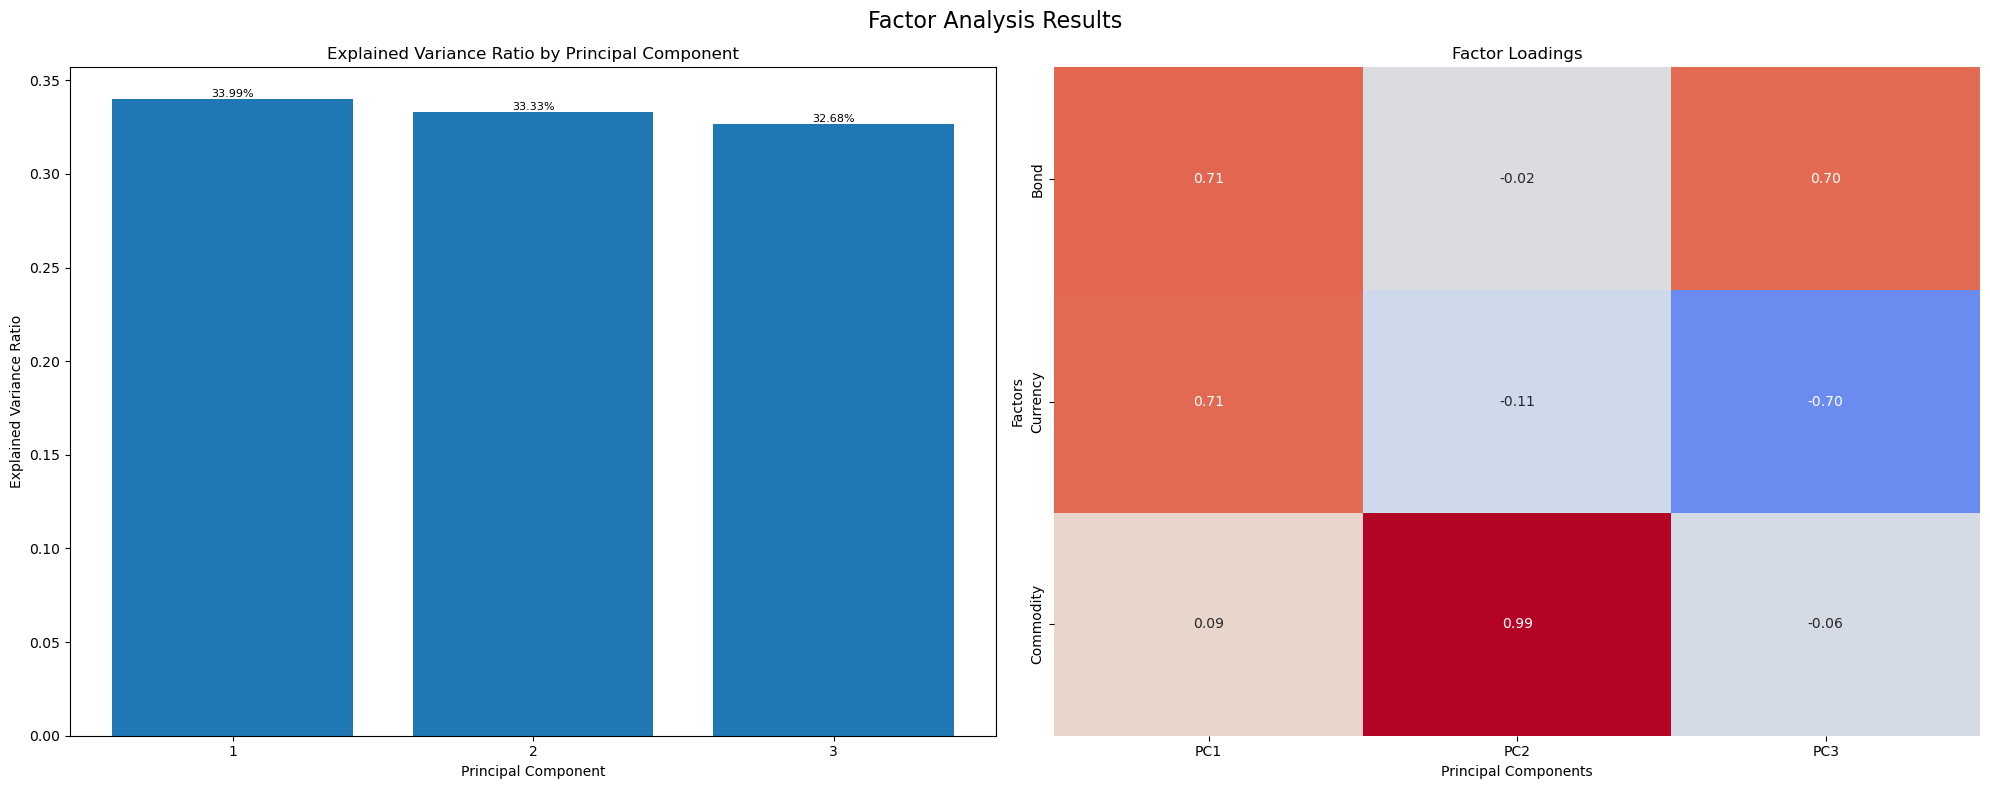


Results for Equity:

Top factor loadings:
PC1    1.515148
PC3    1.457111
PC2    1.124178
dtype: float64


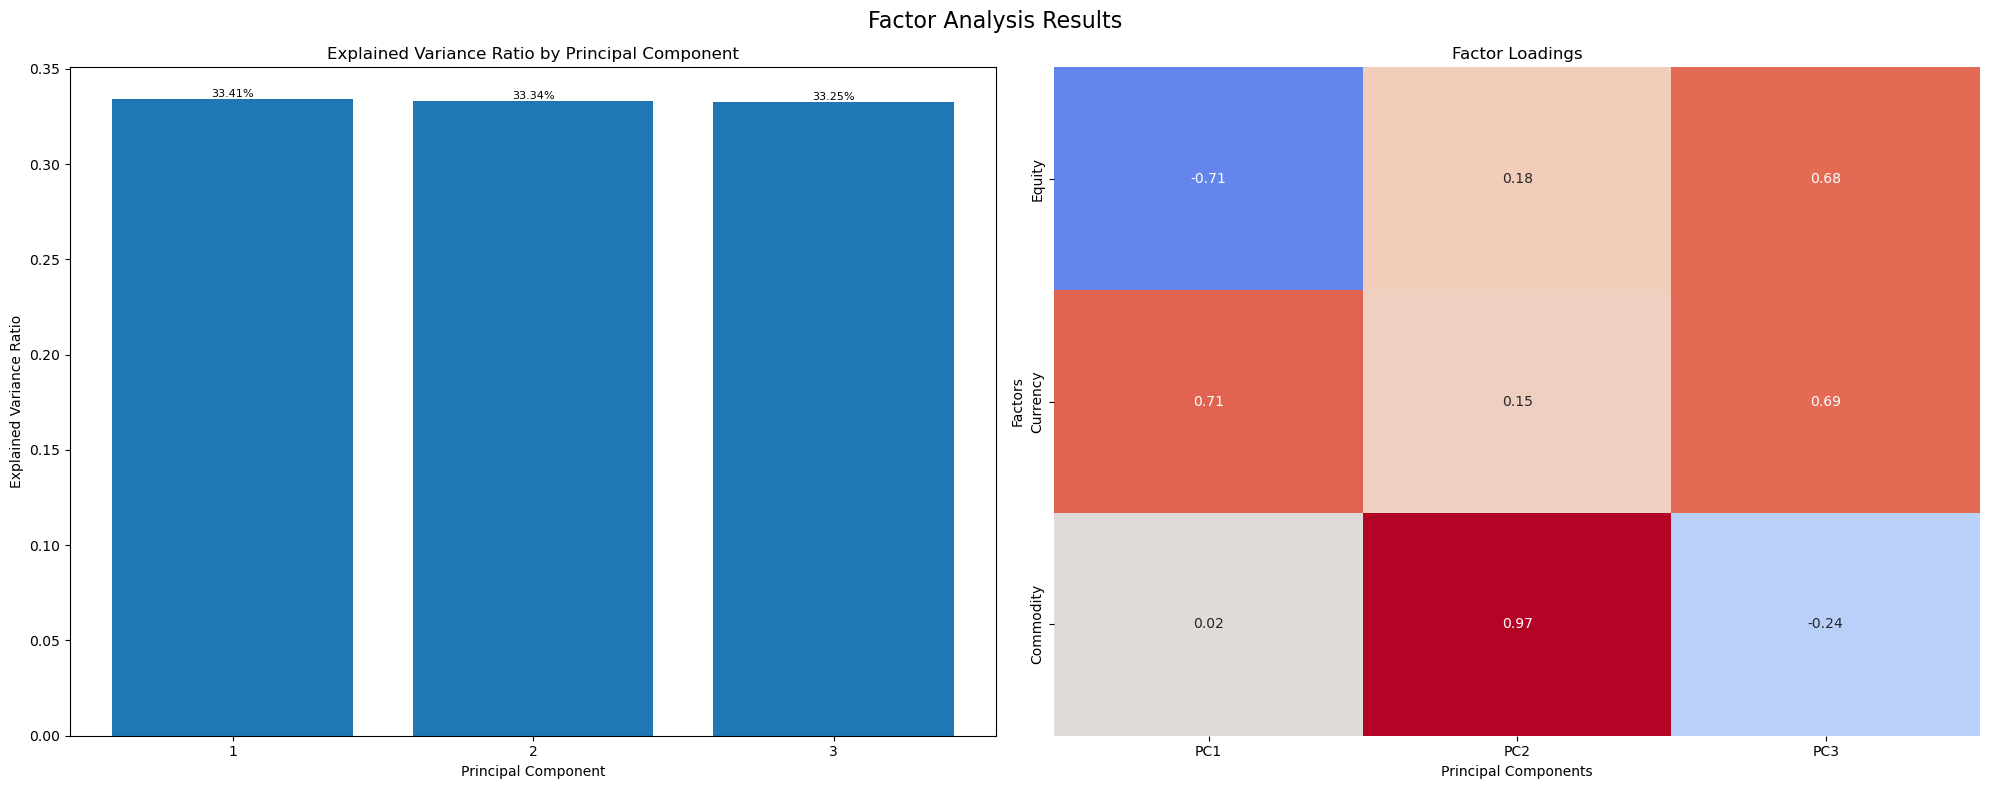


Results for Bond:

Top factor loadings:
PC3    1.610657
PC1    1.437442
PC2    1.309490
dtype: float64


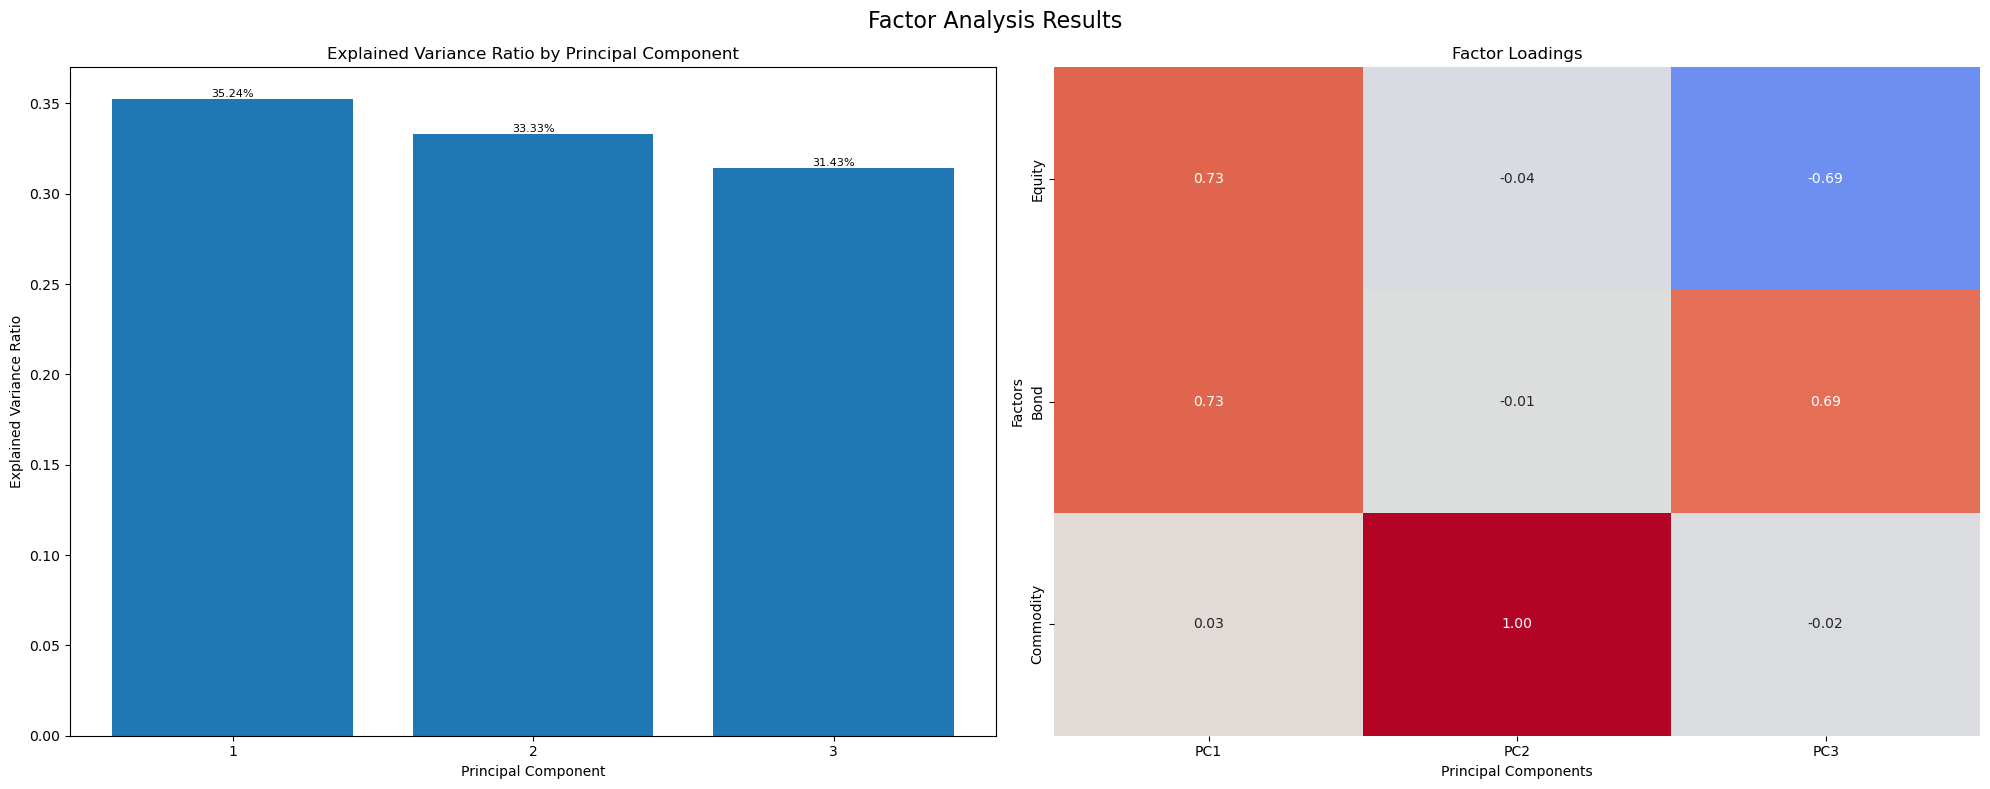


Results for Currency:

Top factor loadings:
PC1    1.485437
PC3    1.393899
PC2    1.043390
dtype: float64


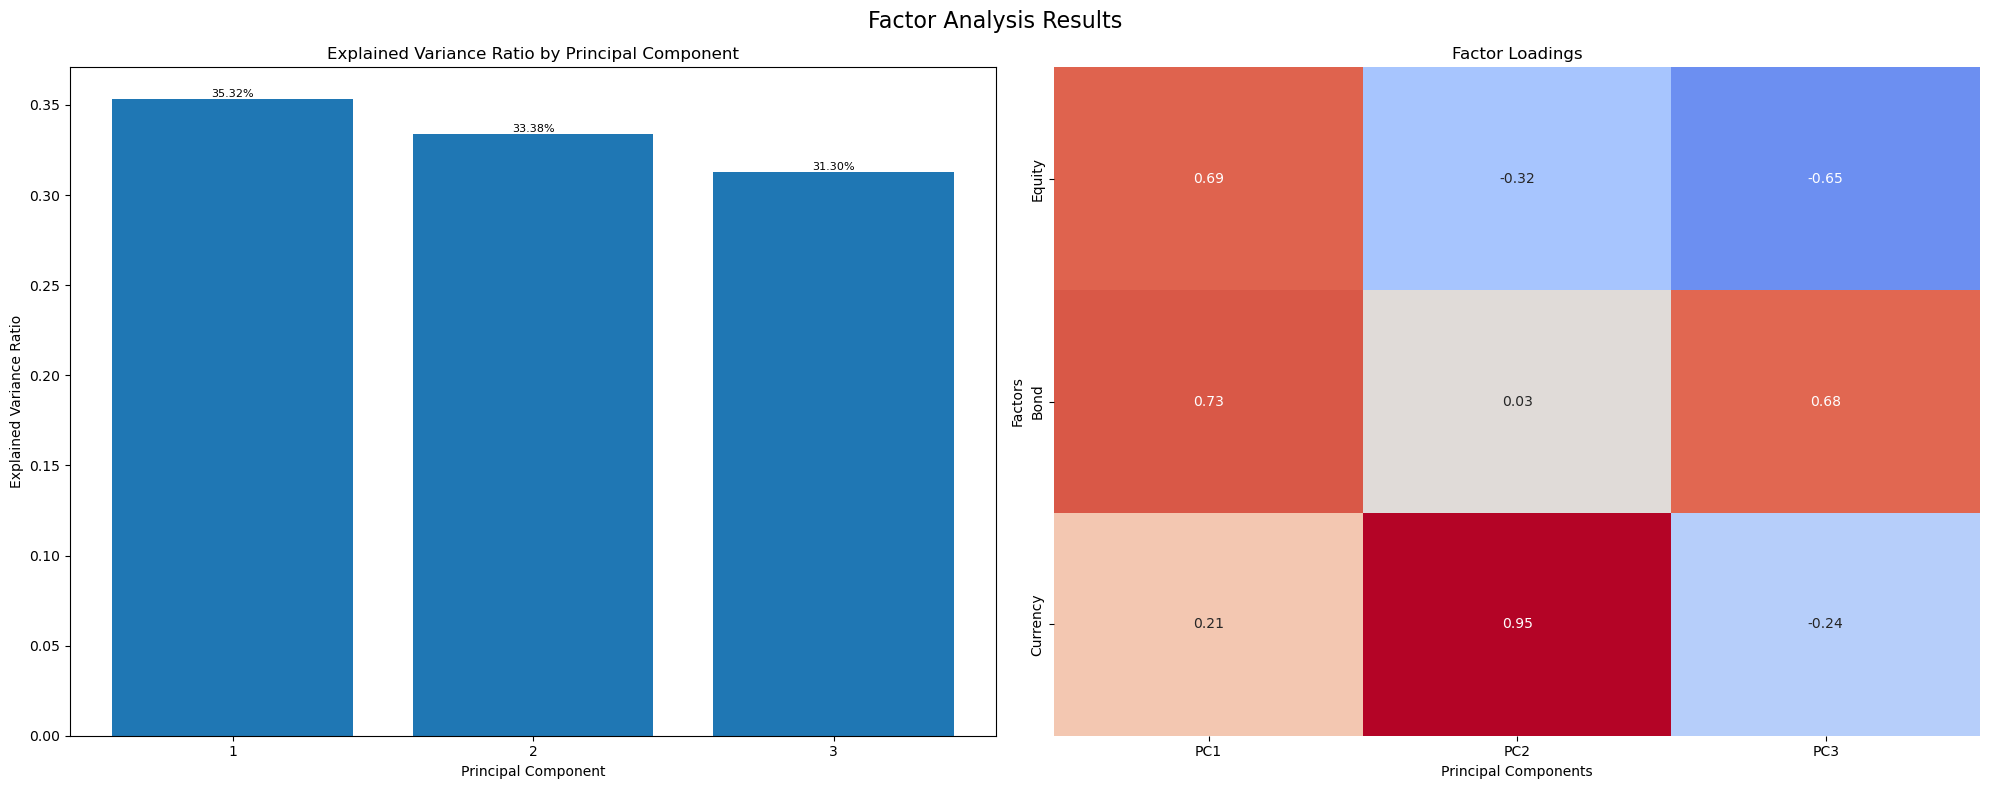


Results for Commodity:

Top factor loadings:
PC1    1.637683
PC3    1.569247
PC2    1.300932
dtype: float64


In [20]:
for asset in combined_returns.columns:
    try:
        returns = combined_returns[asset]
        factors = combined_returns.drop(columns=[asset])
        results = factor_analysis(returns, factors)
        if results:
            loadings, r2, mse = results
            print(f"\nResults for {asset}:")
            print("\nTop factor loadings:")
            print(loadings.abs().sum().sort_values(ascending=False).head())
    except Exception as e:
        print(f"Error processing asset {asset}: {str(e)}")

## Advanced Analytics

In [21]:
#Transaction cost analysis
turnover_rate = 0.5 #Assuming 50% turnover per period
transaction_cost_rate = 0.001 #Assuming 10 bais points transaction cost
net_returns = cal_transaction_costs(combined_returns, turnover_rate, transaction_cost_rate)
print("\nNet Returns After Transaction Costs:")
print(net_returns.mean())


Net Returns After Transaction Costs:
Equity       0.000055
Bond         0.000007
Currency     0.000052
Commodity    0.000024
dtype: float64


In [22]:
# Usage for bootstrap test.
for asset in ['Equity', 'Bond', 'Currency', 'Commodity']:
    print(f"\nProcessing asset: {asset}")
    returns = combined_returns[asset]
    bootstrap_results = bootstrap_test(returns, all_factors)
    if bootstrap_results is not None:
        format_bootstrap_results(bootstrap_results, asset)
    else:
        print("Unable to perform bootstrap test due to data issues.")


Processing asset: Equity

Bootstrap Test Results for Equity
Factor                Mean    Std Dev    p-value
--------------------------------------------------------------------------------
Overreaction        0.0001     0.0000     0.0418
TimeValueRisk       0.0001     0.0000     0.0903
Underreaction      -0.0000     0.0000     0.0562
Underreaction      -0.0000     0.0000     0.0000
TimeValueRisk       0.0000     0.0000     0.4076
Overreaction        0.0000     0.0000     0.1610
Size                0.0000     0.0000     0.0121
Overreaction        0.0000     0.0000     0.3515
TimeValueRisk       0.0000     0.0000     0.3168
Overreaction        0.0000     0.0000     0.4900
--------------------------------------------------------------------------------
Significant Factors (p < 0.05):
- Overreaction   : Mean = 0.0001, p-value = 0.0418
- Underreaction  : Mean = -0.0000, p-value = 0.0000
- Size           : Mean = 0.0000, p-value = 0.0121
- LiquidityRisk  : Mean = -0.0000, p-value = 0.0384


## Cumulative Returns Comparison: Best Portfolio vs. Momentum Strategy

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


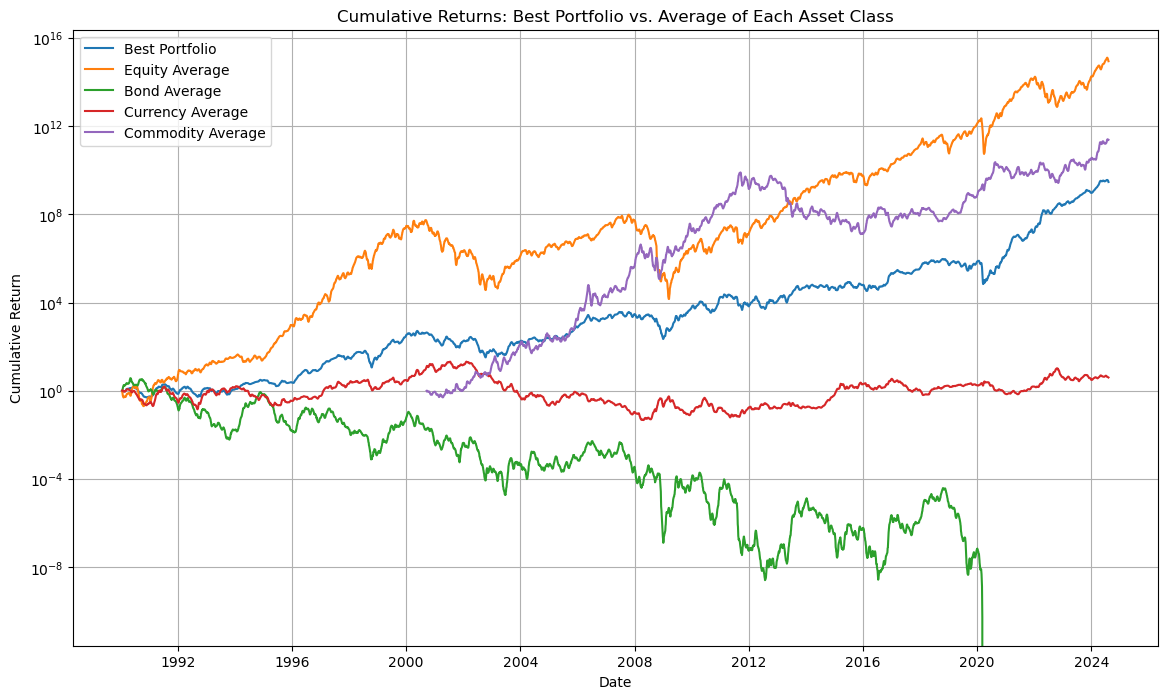

Momentum investing improves returns the most in the Currency asset class.
Equity: -100.00% improvement with momentum strategy.
Bond: -331869884570675.69% improvement with momentum strategy.
Currency: 73584728301.48% improvement with momentum strategy.
Commodity: -98.78% improvement with momentum strategy.


In [23]:
# Define tickers for different asset classes
asset_classes = {
    'Equity': ['^GSPC'],
    'Bond': ['^TNX'],  # 10-Year Treasury Note
    'Currency': ['^NYICDX'],  # US Dollar Index
    'Commodity': ['GC=F'],  # Gold Futures
}

# Create an empty DataFrame to store cumulative returns
cumulative_returns = pd.DataFrame()

# Create an empty DataFrame to store all momentum returns for forming the best portfolio
all_momentum_data = pd.DataFrame()

# Load and process data for each asset class
for asset_class, tickers in asset_classes.items():
    # Load the data
    data = yf.download(tickers, start='1990-01-01', end='2024-08-07')['Adj Close']
    
    # Ensure the data is processed correctly
    data = data.dropna()
    
    # Calculate returns
    returns = data.pct_change()
    
    # Calculate momentum returns (12-month lookback period)
    momentum_returns = returns.rolling(window=12).sum()
    
    # Store momentum returns in the combined DataFrame
    all_momentum_data[asset_class] = momentum_returns.squeeze()

# Calculate the best portfolio by averaging momentum returns across all asset classes
best_portfolio_returns = all_momentum_data.mean(axis=1)

# Calculate cumulative returns for the best portfolio
cumulative_returns['Best Portfolio'] = (1 + best_portfolio_returns).cumprod()

# Calculate cumulative returns for each asset class
for asset_class, tickers in asset_classes.items():
    # Calculate the average returns across the asset class
    class_returns = all_momentum_data[asset_class]
    #class_returns = combined_asset_data.pct_change().mean(axis=1)
    
    # Calculate cumulative returns for the asset class
    cumulative_returns[asset_class + ' Average'] = (1 + class_returns).cumprod()

# Plotting cumulative returns for the best portfolio and each asset class
plt.figure(figsize=(14, 8))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
    
plt.title('Cumulative Returns: Best Portfolio vs. Average of Each Asset Class')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.yscale('log')
plt.grid(True)
plt.show()

# Performance comparison
performance_comparison = {}

for asset_class in asset_classes.keys():
    portfolio_return = cumulative_returns['Best Portfolio'].iloc[-1]
    class_average_return = cumulative_returns[asset_class + ' Average'].iloc[-1]
    improvement = (portfolio_return - class_average_return) / class_average_return
    performance_comparison[asset_class] = improvement

best_asset_class = max(performance_comparison, key=performance_comparison.get)
print(f"Momentum investing improves returns the most in the {best_asset_class} asset class.")

# Print improvement percentages with additional checks for edge cases
for asset_class, improvement in performance_comparison.items():
    if pd.isna(improvement) or improvement == float('inf'):
        print(f"{asset_class}: Improvement is not calculable (division by zero or identical returns).")
    else:
        print(f"{asset_class}: {improvement:.2%} improvement with momentum strategy.")

    
